In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.append("../../../")

import gc
import getpass
import pickle
from pathlib import Path

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from loguru import logger
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from povertymapping import nightlights, settings
from povertymapping.dhs import generate_dhs_cluster_level_data
from povertymapping.feature_engineering import (
    categorize_wealth_index,
    generate_features,
)
from povertymapping.iso3 import get_region_name
from povertymapping.ookla import OoklaDataManager
from povertymapping.osm import get_osm_extent
from povertymapping.rollout_grids import get_region_filtered_bingtile_grids

/home/jc_tm/project_repos/unicef-ai4d-poverty-mapping/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model Prediction on Rollout Grids: Indonesia

This notebook is the final step in the rollout and runs the final model to create relative wealth estimations over populated areas within the given country. The model predictions will have a spatial resolution of 2.4km.

The `predicted relative wealth` value gives us the relative wealth level of an area compared to the rest of the country, which fixes the value range from 0 (lowest wealth) to 1 (highest wealth). In between these extremes, each area's wealth estimate is scaled to a value between 0 and 1.

The predicted relative wealth value is later binned into 5 wealth categories A-E by dividing the distribution into quintiles (every 20th percentile).

## Set up Data Access
The following cell will prompt you to enter your EOG username and password. See [this page](https://eogdata.mines.edu/products/register/) to learn how to set-up your EOG account.

In [ ]:
# Log-in using EOG credentials
username = os.environ.get("EOG_USER", None)
username = username if username is not None else input("Username?")
password = os.environ.get("EOG_PASSWORD", None)
password = password if password is not None else getpass.getpass("Password?")

# set save_token to True so that access token gets stored in ~/.eog_creds/eog_access_token
access_token = nightlights.get_eog_access_token(username, password, save_token=True)

## Set country-specific parameters
For Indonesia, we need to process the OSM data per subregion, listed in `country_subareas_osm`

In [4]:
COUNTRY_CODE = "id"
COUNTRY_SUBAREAS_OSM = [
    "maluku",
    "sulawesi",
    "sumatra",
    "java",
    "kalimantan",
    "nusa-tenggara",
    "papua",
]

OOKLA_YEAR = 2019
NIGHTLIGHTS_YEAR = 2019

rollout_date = "-".join(os.getcwd().split("/")[-2].split("-")[:3])
rollout_grids_path = Path(f"./{rollout_date}-{COUNTRY_CODE}-rollout-grids.geojson")
rollout_grids_path

Path('2023-02-21-id-rollout-grids.geojson')

## Set Model Parameters

In [5]:
# Model to use for prediction
MODEL_SAVE_PATH = Path(f"../{rollout_date}-cross-country-model.pkl")

## Load Country Rollout AOI

The rollout area of interest is split into 2.4km grid tiles (zoom level 14), matching the areas used during model training. The grids are also filtered to only include populated areas based on Meta's High Resolution Settlement Layer (HRSL) data.

Refer to the previous notebook `2_id_generate_grids.ipynb` for documentation on generating this grid.

In [6]:
aoi = gpd.read_file(rollout_grids_path)
aoi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 161230 entries, 0 to 161229
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   quadkey         161230 non-null  object  
 1   shapeName       161230 non-null  object  
 2   shapeISO        161230 non-null  object  
 3   shapeID         161230 non-null  object  
 4   shapeGroup      161230 non-null  object  
 5   shapeType       161230 non-null  object  
 6   quadkey_level8  161230 non-null  object  
 7   pop_count       161230 non-null  float64 
 8   geometry        161230 non-null  geometry
dtypes: float64(1), geometry(1), object(7)
memory usage: 11.1+ MB


## Generate Features For Rollout AOI

If this is your first time running this notebook for this specific area, expect a long runtime for the following cell as it will download and cache the required datasets. It will then process the relevant features for each area specified. On subsequent runs, the runtime will be much faster as the data is already stored in your filesystem. 

### Retrieve base data 
Unlike the rollouts for the other countries, we need to generate the features in batches for Indonesia. We will first get the data per subarea, combine them, then scale them afterwards to get the final features set.

In [7]:
%%time
subarea_data_list = []
for subarea_osm in COUNTRY_SUBAREAS_OSM:
    subarea_extent = get_osm_extent(subarea_osm)
    aoi_in_subarea = (
        gpd.sjoin(aoi, subarea_extent, how="inner", predicate="intersects")
        .drop(columns=["index_right"])
        .reset_index(drop=True)
    )
    logger.info(
        f"Processing aoi grids in osm_region: {subarea_osm} (n = {len(aoi_in_subarea)})"
    )

    aoi_in_subarea = generate_features(
        aoi_in_subarea,
        subarea_osm,
        ookla_year=OOKLA_YEAR,
        nightlights_year=NIGHTLIGHTS_YEAR,
        scale=False,
        features_only=False,
        use_aoi_quadkey=True,
        aoi_quadkey_col="quadkey",
    )
    subarea_data_list.append(aoi_in_subarea)

# Combine all country data into a single dataframe
aoi_data = gpd.GeoDataFrame(
    pd.concat(subarea_data_list, ignore_index=True), crs=subarea_data_list[0].crs
)

# There may be duplicates for rows that are in between two subareas.
# For now we will just keep the first occurence
aoi_data = aoi_data.drop_duplicates("quadkey")

2023-03-27 13:59:24.581 | INFO     | __main__:<module>:10 - Processing aoi grids in osm_region: maluku (n = 5382)
2023-03-27 13:59:24.604 | INFO     | povertymapping.osm:download_osm_country_data:199 - OSM Data: Cached data available for maluku at /home/jc_tm/.geowrangler/osm/maluku? True
2023-03-27 13:59:24.605 | DEBUG    | povertymapping.osm:load_pois:161 - OSM POIs for maluku being loaded from /home/jc_tm/.geowrangler/osm/maluku/gis_osm_pois_free_1.shp
2023-03-27 13:59:26.544 | INFO     | povertymapping.osm:download_osm_country_data:199 - OSM Data: Cached data available for maluku at /home/jc_tm/.geowrangler/osm/maluku? True
2023-03-27 13:59:26.545 | DEBUG    | povertymapping.osm:load_roads:180 - OSM Roads for maluku being loaded from /home/jc_tm/.geowrangler/osm/maluku/gis_osm_roads_free_1.shp
2023-03-27 13:59:28.400 | DEBUG    | povertymapping.ookla:load_type_year_data:79 - Contents of data cache: []
2023-03-27 13:59:28.401 | INFO     | povertymapping.ookla:load_type_year_data:94 

CPU times: user 14min 56s, sys: 1min 51s, total: 16min 48s
Wall time: 17min 15s


In [8]:
aoi_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 161230 entries, 0 to 161238
Data columns (total 71 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   quadkey                            161230 non-null  object  
 1   shapeName                          161230 non-null  object  
 2   shapeISO                           161230 non-null  object  
 3   shapeID                            161230 non-null  object  
 4   shapeGroup                         161230 non-null  object  
 5   shapeType                          161230 non-null  object  
 6   quadkey_level8                     161230 non-null  object  
 7   pop_count                          161230 non-null  float64 
 8   geometry                           161230 non-null  geometry
 9   osm_region                         161230 non-null  object  
 10  poi_count                          161230 non-null  float64 
 11  atm_count         

### Scale and clean features

In [9]:
# Get list of raw features generated
feature_cols = [
    x for x in aoi_data.columns if x not in list(aoi.columns) + ["osm_region"]
]

In [11]:
%%time
scaler = MinMaxScaler()
rollout_aoi = aoi_data[
    [col for col in aoi_data.columns if col not in feature_cols]
].copy()
features = aoi_data[feature_cols].copy()

for col in feature_cols:
    max_val = features[[col]].max()
    features[col + "_scaled"] = scaler.fit_transform(
        features[[col]].clip(upper=max_val, axis=1)
    )

CPU times: user 3.4 s, sys: 0 ns, total: 3.4 s
Wall time: 3.4 s


In [ ]:
# Save raw features, can be used for validation
raw_features = features[[col for col in features.columns if "_scaled" not in col]]
# Then keep only scaled columns
features = features[[col for col in features.columns if "_scaled" in col]]

## Inspect the generated features

In [13]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161230 entries, 0 to 161238
Data columns (total 61 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   poi_count_scaled                          161230 non-null  float64
 1   atm_count_scaled                          161230 non-null  float64
 2   atm_nearest_scaled                        161230 non-null  float64
 3   bank_count_scaled                         161230 non-null  float64
 4   bank_nearest_scaled                       161230 non-null  float64
 5   bus_station_count_scaled                  161230 non-null  float64
 6   bus_station_nearest_scaled                161230 non-null  float64
 7   cafe_count_scaled                         161230 non-null  float64
 8   cafe_nearest_scaled                       161230 non-null  float64
 9   charging_station_count_scaled             161230 non-null  float64
 10  charging_station_nea

## Run Model on AOI

### Load Model

In [14]:
with open(MODEL_SAVE_PATH, "rb") as f:
    model = pickle.load(f)

### Make Predictions

In [15]:
rollout_aoi["Predicted Relative Wealth Index"] = model.predict(features.values)

## Binning predictions into wealth categories

Afterwards, we label the predicted relative wealth by binning them into 5 categories: `A`, `B`, `C`, `D`, and `E` where `A` is the highest and `E` is the lowest. 

We can create these wealth categories by splitting the output `Predicted Relative Wealth Index` distribution into 5 equally sized **quintiles**, i.e. every 20th percentile. 

This categorization may be modified to suit the context of the target country.

In [ ]:
rollout_aoi["Predicted Wealth Category (quintile)"] = categorize_wealth_index(
    rollout_aoi["Predicted Relative Wealth Index"]
).astype(str)

In [ ]:
rollout_aoi.info()

In [ ]:
rollout_aoi.head(2)

## Save output

In [23]:
%%time
rollout_aoi.to_file(
    f"{rollout_date}-{COUNTRY_CODE}-rollout-output.geojson",
    driver="GeoJSON",
    index=False,
)

CPU times: user 39.8 s, sys: 851 ms, total: 40.7 s
Wall time: 40.7 s


In [24]:
# Join back raw features and save
rollout_output_with_features = rollout_aoi.join(raw_features).join(features)
rollout_output_with_features.to_file(
    f"{rollout_date}-{COUNTRY_CODE}-rollout-output-with-features.geojson",
    driver="GeoJSON",
    index=False,
)

## Visualizations

### Inspect predicted wealth index and output dataframe

array([[<AxesSubplot: title={'center': 'Predicted Relative Wealth Index'}>]],
      dtype=object)

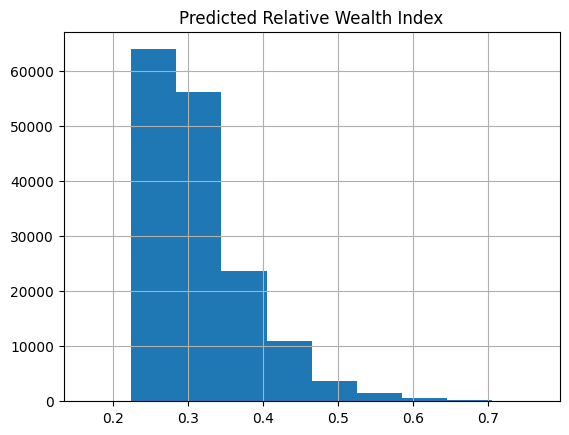

In [16]:
rollout_aoi[["Predicted Relative Wealth Index"]].hist()

### Create Static Maps
#### Plot Predicted Relative Wealth Index

<Figure size 640x480 with 0 Axes>

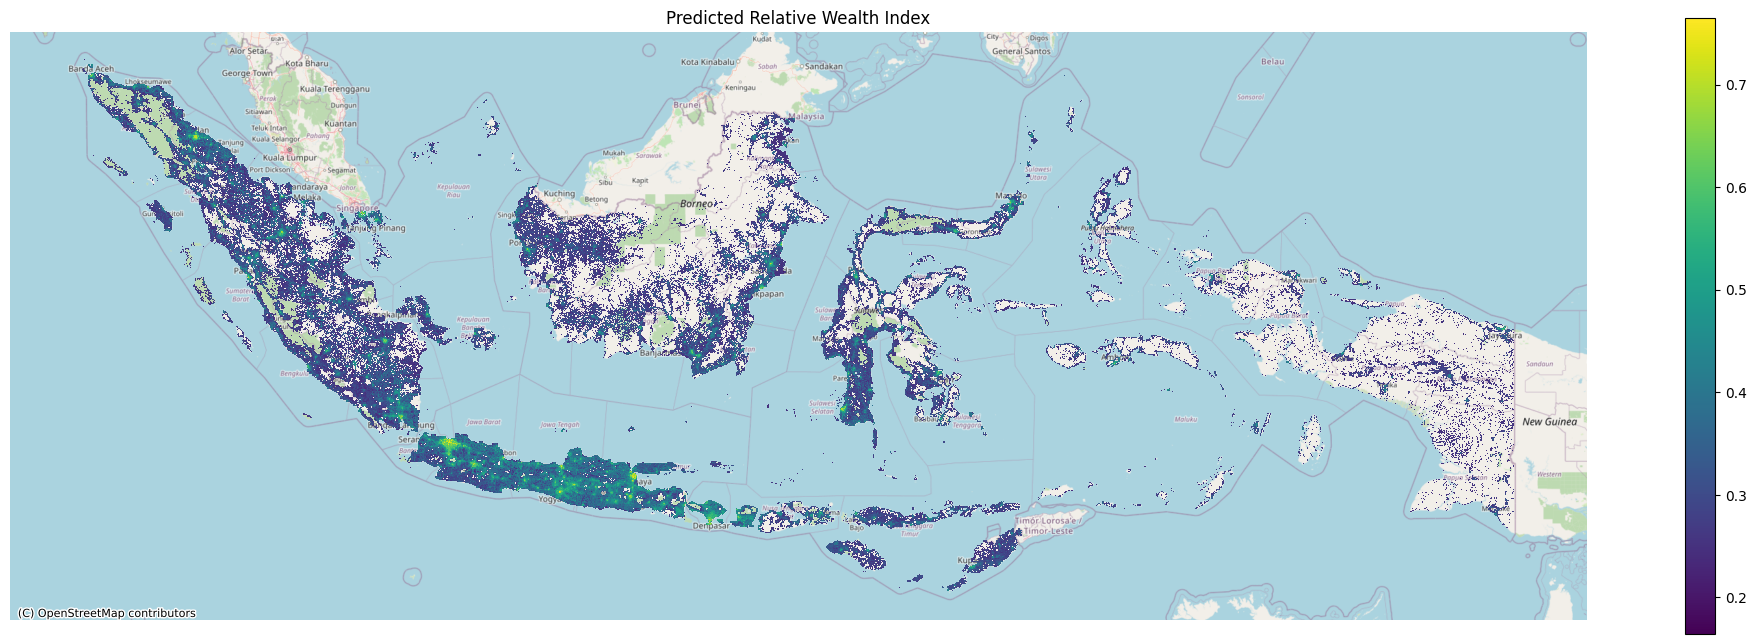

In [17]:
plt.cla()
plt.clf()
rollout_aoi_plot = rollout_aoi.to_crs("EPSG:3857")
ax = rollout_aoi_plot.plot(
    "Predicted Relative Wealth Index",
    figsize=(20, 8),
    cmap="viridis",
    legend=True,
    legend_kwds={"shrink": 0.8},
)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title("Predicted Relative Wealth Index")
plt.tight_layout()
plt.savefig(f"{rollout_date}-{COUNTRY_CODE}-predicted-wealth-index.png")
plt.show()

#### Plot Predicted Relative Wealth Index Category

<Figure size 640x480 with 0 Axes>

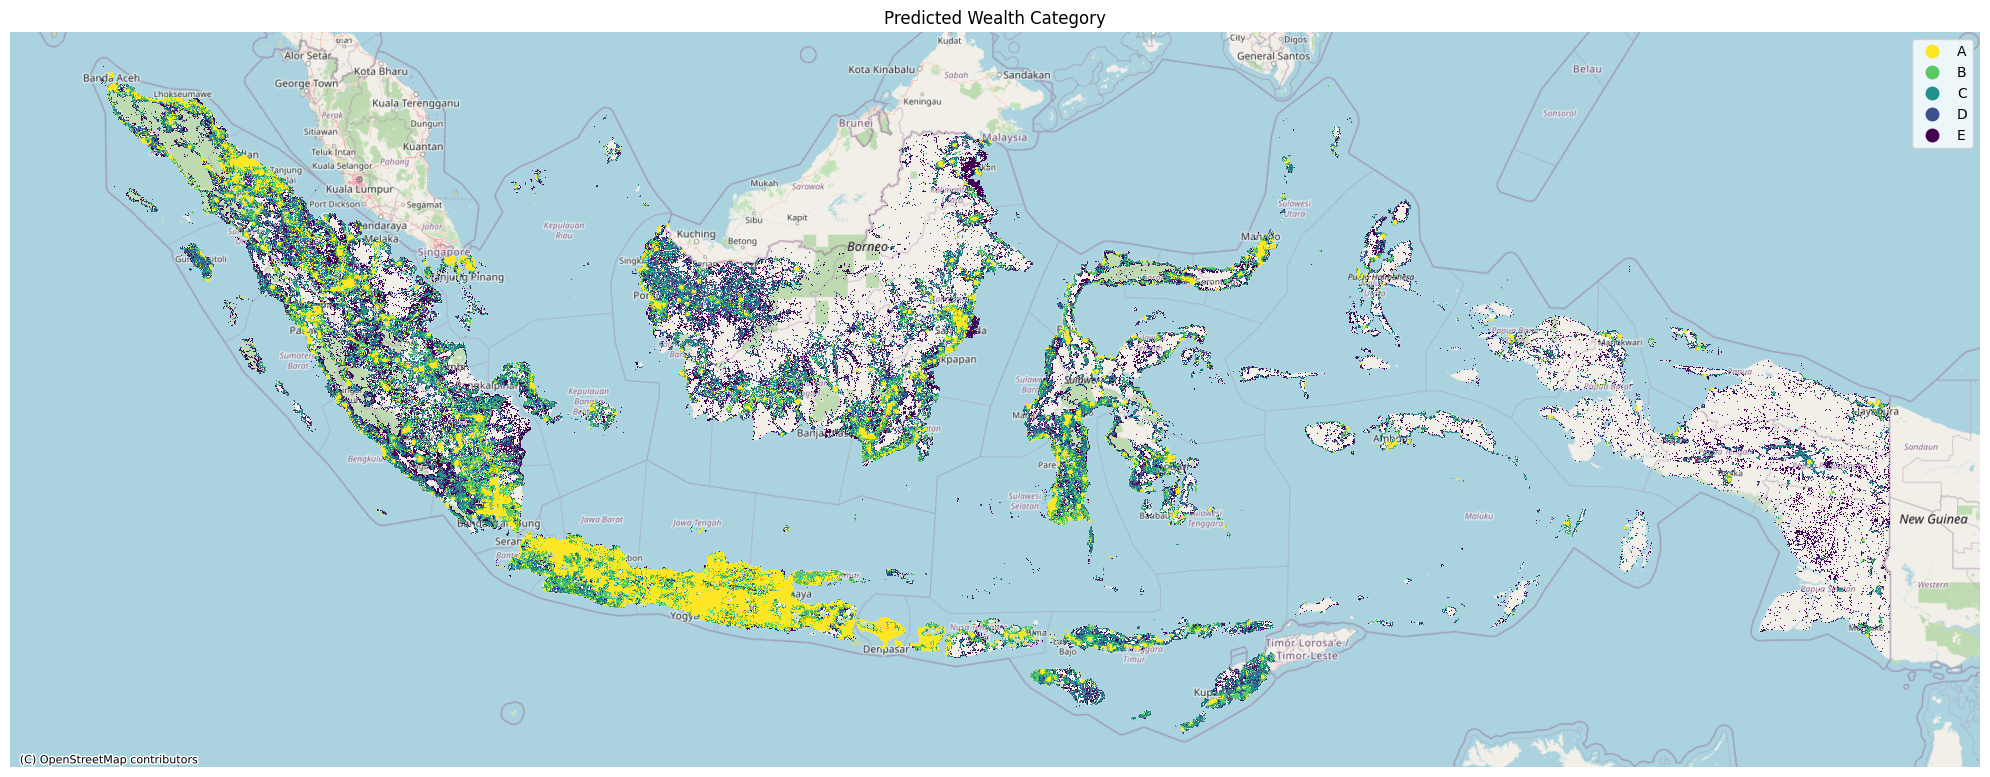

In [21]:
plt.cla()
plt.clf()
rollout_aoi_plot = rollout_aoi.to_crs("EPSG:3857")
ax = rollout_aoi_plot.plot(
    "Predicted Wealth Category (quintile)",
    figsize=(20, 8),
    cmap="viridis_r",
    legend=True,
)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title("Predicted Wealth Category")
plt.tight_layout()
plt.savefig(f"{rollout_date}-{COUNTRY_CODE}-predicted-wealth-bin.png")
plt.show()

### Create an Interactive Map

In [22]:
cols_of_interest = [
    "quadkey",
    "shapeName",
    "shapeGroup",
    "pop_count",
    "avg_rad_mean",
    "mobile_2019_mean_avg_d_kbps_mean",
    "fixed_2019_mean_avg_d_kbps_mean",
    "poi_count",
    "road_count",
    "Predicted Relative Wealth Index",
    "Predicted Wealth Category (quintile)",
]

# Warning: This can be a bit laggy due to the large amount of tiles being visualized

# Uncomment the ff if you want to viz the raw wealth predictions
# rollout_aoi.explore(column='Predicted Relative Wealth Index', tooltip=cols_of_interest, cmap="viridis")

# Uncomment the ff if you want to view the quintiles
# rollout_aoi.explore(column='Predicted Wealth Category (quintile)', tooltip=cols_of_interest, cmap="viridis_r")

Alternatively, you may also try to visualize this interactively in [Kepler](https://kepler.gl/demo) by uploading the rollout output geojson file.